In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from GibsonPrediction.clustering import read_starcode_results, cluster_counter_to_count_df
from GibsonPrediction.utils import contains_RE_site, get_fold_change

The reads from the assembled library were appended to the reads from the input library before clustering. I want to separate them back into input vs assembled, so I need to determine how many reads were in the input library. I'll read in the reads from the input and make sure they're all length 30 before counting how many there are.

In [2]:
with open('../data/starcode_counts/GP_PCR_4_trimmed.txt', 'r') as f:
  input_reads = [line.rstrip() for line in f]

print(sum([len(read) != 30 for read in input_reads]))
print(len(input_reads))

total_reads_input = len(input_reads)

0
14150509


Read in clusters from starcode output, as well as the input file so that individual cluster IDs can be mapped back to their original sequences.

In [3]:
clustered_path = '../data/starcode_counts/PCR_large_rep2_clustered_d3.txt'
unclustered_path = '../data/starcode_counts/PCR_large_rep2.txt'

In [4]:
cluster_counts_input, cluster_counts_assembled = read_starcode_results(clustered_path, unclustered_path, input_count=total_reads_input)

In [5]:
count_df = cluster_counter_to_count_df(cluster_counts_input, cluster_counts_assembled)
count_df.head()

,sequence,input_count,assembled_count
0,TATATATTTGCTACTTCCGCTCCTTTCAGT,30,30
1,TCGATGTGCAGAGGTCCAAAGTTATGTGAT,15,7
2,TGGCATTCTTACAGATTGGCTATCGAGTGG,18,25
3,TGATGCCAGGGCGCGGTAACTGGGAGTGCG,18,19
4,TTGCGGTGCGAGGAAATATGGTAATCATTC,2,3


In [6]:
del cluster_counts_input, cluster_counts_assembled

Look at cluster stats.

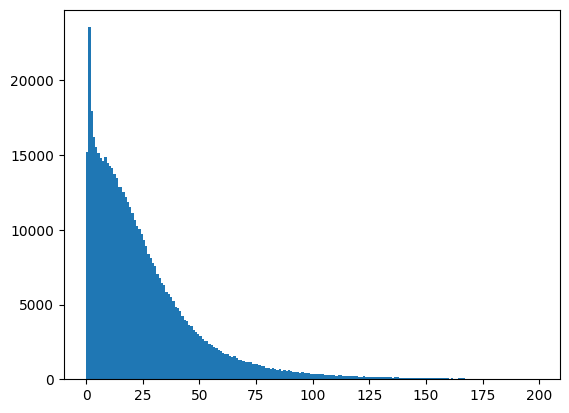

Median count: 18.0
count    557232.000000
mean         25.394286
std          26.011518
min           0.000000
25%           8.000000
50%          18.000000
75%          34.000000
max         506.000000
Name: input_count, dtype: float64


In [7]:
plt.hist(count_df['input_count'], bins=range(200))
plt.show()
print(f"Median count: {count_df['input_count'].median()}")
print(count_df['input_count'].describe())


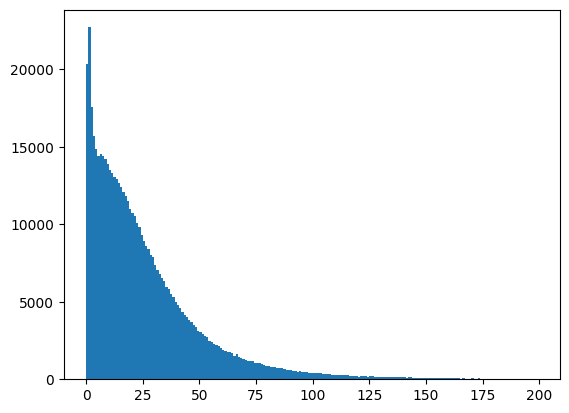

Median count: 19.0
count    557232.000000
mean         26.033573
std          26.715883
min           0.000000
25%           8.000000
50%          19.000000
75%          35.000000
max         471.000000
Name: assembled_count, dtype: float64


In [8]:
plt.hist(count_df['assembled_count'], bins=range(200))
plt.show()
print(f"Median count: {count_df['assembled_count'].median()}")
print(count_df['assembled_count'].describe())

See if any sequences have input count of 0 before calculating fold change

In [9]:
count_df[count_df['input_count'] == 0].sort_values('assembled_count', ascending=False)

,sequence,input_count,assembled_count
81974,GTATCGGGCAATTAGGGCGATATTATGTCA,0,19
326644,TATCTTGGTGACGATAATATCATGCACAGG,0,18
326117,ACGGGAAGCGGGGAAGCGTGGTTCGGGCAG,0,15
38207,GTACGAGCTTTACCCATGGAGCCGGACTGA,0,15
141371,GTGGGAATGAGTACAATGTGATTAGAAGGC,0,14
...,...,...,...
236976,CCCTAAGTACGGTTACCTAGGTAAAGATGG,0,1
237071,GCGTCCTCGCGTTATAAACACAGGACAGGC,0,1
237093,GGGCACAGTGTGGGGGTAGCCGTGACACTG,0,1
237325,GGCCCACGCTCGACCGGGATTTATTGGGTC,0,1


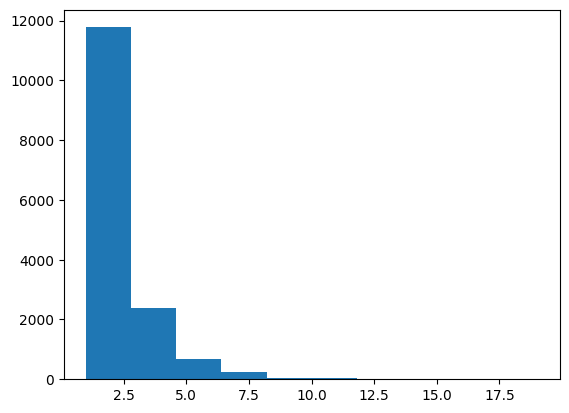

In [10]:
plt.hist(count_df[count_df['input_count'] == 0]['assembled_count'])
plt.show()

Look at distribution of ratio between assembled and input counts for each cluster.

In [11]:
count_df['fold_change'] = get_fold_change(count_df, 1, 1)
count_df['log2_FC'] = np.log2(count_df['fold_change'])
count_df.head()

,sequence,input_count,assembled_count,fold_change,log2_FC
0,TATATATTTGCTACTTCCGCTCCTTTCAGT,30,30,0.975444,-0.035869
1,TCGATGTGCAGAGGTCCAAAGTTATGTGAT,15,7,0.487722,-1.035869
2,TGGCATTCTTACAGATTGGCTATCGAGTGG,18,25,1.334818,0.416643
3,TGATGCCAGGGCGCGGTAACTGGGAGTGCG,18,19,1.026783,0.038131
4,TTGCGGTGCGAGGAAATATGGTAATCATTC,2,3,1.300592,0.379168


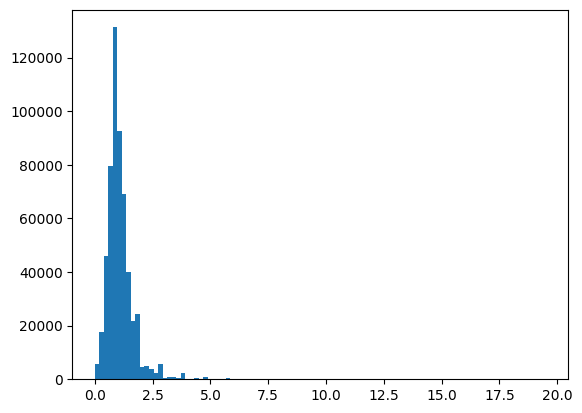

In [12]:
plt.hist(count_df['fold_change'], bins=100)
plt.show()

Look at stats for log fold change

count    557232.000000
mean         -0.032381
std           0.768060
min          -8.344208
25%          -0.381005
50%          -0.035869
75%           0.379168
max           4.286059
Name: log2_FC, dtype: float64


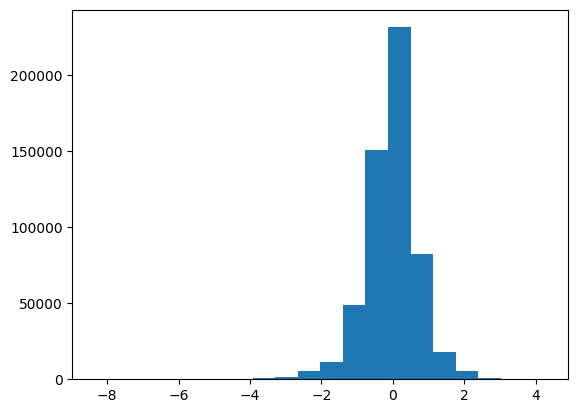

In [13]:
print(count_df['log2_FC'].describe())
plt.hist(count_df['log2_FC'], bins=20)
plt.show()

Look at best and worst sequences for Gibson assembly

In [14]:
count_df[(count_df['input_count'] > 100) & (count_df['assembled_count'] < 20)].sort_values('log2_FC')

,sequence,input_count,assembled_count,fold_change,log2_FC
171239,TGCGGCAATCCTGCCGGATGATTCGGTATT,316,0,0.003077,-8.344208
473041,CTTGAAAGTTAGAAACCGAATTGGTCTACC,301,0,0.003230,-8.274274
473730,CAGATTGCACTGAAAGTGAAGTTGGCGAGG,294,0,0.003307,-8.240441
65289,GCCAGACTTTAAGGAGTCCATGAACTGCTG,287,0,0.003387,-8.205794
444225,TGCAGACGGCCCGAACTGGGATTAGCTTGG,278,0,0.003496,-8.159991
...,...,...,...,...,...
470837,GTCACCAATGAGTTTAAGTCATTGATTATG,162,18,0.113702,-3.136670
304316,GGAATCTTTTGCGCAGGAGGCGCAAGTCAT,105,13,0.128832,-2.956435
447159,GTGAGGCACGACACGCCTCCGGCGGTCGTA,106,15,0.145861,-2.777336
310355,GCCGAAACCAGCGTTGGCTGGTTATAAGAG,113,19,0.171130,-2.546831


In [15]:
count_df[(count_df['input_count'] > 20)].sort_values('log2_FC', ascending=False)

,sequence,input_count,assembled_count,fold_change,log2_FC
152601,TTTCTATGGGTAAAGGGGTGGTCTCGCGGT,30,90,2.863399,1.517729
218500,GTGATCAGTCATCGGGGGTATGCGACACGT,22,66,2.841510,1.506658
155344,GAACGGATCATTAATGTGTCTGCGCATGGC,22,62,2.671868,1.417849
41331,TTCGTTAGGCGGGTGTCGCAGAGAAAAACG,30,82,2.611672,1.384974
383782,GTGTTGGAAGGCTCGTTCACCTTAGTAATG,23,63,2.601183,1.379168
...,...,...,...,...,...
444225,TGCAGACGGCCCGAACTGGGATTAGCTTGG,278,0,0.003496,-8.159991
65289,GCCAGACTTTAAGGAGTCCATGAACTGCTG,287,0,0.003387,-8.205794
473730,CAGATTGCACTGAAAGTGAAGTTGGCGAGG,294,0,0.003307,-8.240441
473041,CTTGAAAGTTAGAAACCGAATTGGTCTACC,301,0,0.003230,-8.274274


Remove sequences that contain a BspQI site and look at worst sequences again.


In [16]:
mask = count_df['sequence'].apply(lambda x: contains_RE_site(x, 'GCTCTTC'))
count_df[mask].sort_values('input_count', ascending=False).head()
# count_df[mask].sort_values('input_count', ascending=False).to_csv('cut.csv', sep='\t')

,sequence,input_count,assembled_count,fold_change,log2_FC
463221,AGTTAATAACCGGGCTGGGCTCTTCGTGTG,277,0,0.003509,-8.154810
527514,CCTTGAGGAGGCTCTTCTCGGAGGCCACGC,270,109,0.395937,-1.336659
21409,TAATTGGTTCATTCATCACGCTCTTCTTAT,142,0,0.006821,-7.195741
99213,GGTTGATTGTGCTCTTCGAGGCTCGGTCGA,141,13,0.096171,-3.378262
383733,TATGCGATACGCTCTTCTCGTCTTGTTATG,140,4,0.034590,-4.853493


In [17]:
count_df_no_cut = count_df[~mask]
count_df_no_cut[(count_df_no_cut['input_count'] > 100) & (count_df_no_cut['assembled_count'] < 20)].sort_values('log2_FC')

,sequence,input_count,assembled_count,fold_change,log2_FC
171239,TGCGGCAATCCTGCCGGATGATTCGGTATT,316,0,0.003077,-8.344208
473041,CTTGAAAGTTAGAAACCGAATTGGTCTACC,301,0,0.003230,-8.274274
473730,CAGATTGCACTGAAAGTGAAGTTGGCGAGG,294,0,0.003307,-8.240441
65289,GCCAGACTTTAAGGAGTCCATGAACTGCTG,287,0,0.003387,-8.205794
444225,TGCAGACGGCCCGAACTGGGATTAGCTTGG,278,0,0.003496,-8.159991
...,...,...,...,...,...
470837,GTCACCAATGAGTTTAAGTCATTGATTATG,162,18,0.113702,-3.136670
304316,GGAATCTTTTGCGCAGGAGGCGCAAGTCAT,105,13,0.128832,-2.956435
447159,GTGAGGCACGACACGCCTCCGGCGGTCGTA,106,15,0.145861,-2.777336
310355,GCCGAAACCAGCGTTGGCTGGTTATAAGAG,113,19,0.171130,-2.546831
